## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №32. Часть 1.

#### Загрузка и предобработка данных
Cоздать датафрейм содержащий относительный путь к изображению и целевую метку, который потом использовать при обучении

In [1]:
import os
import sys
import wget
import shutil
import tarfile

import re
import numpy as np
import pandas as pd

import cv2
import dlib
from PIL import Image
from imutils import face_utils
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

DATA_URL = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'
DATA_FILE = 'wiki_crop.tar'
DATA_FOLDER = 'wiki_crop'

print('OpenCV version ' + cv2.__version__)

OpenCV version 4.7.0


Загрузим файл с данными по ссылке (если файл не найден на диске)

In [2]:
def bar_custom(current, total, width=80):
    progress_msg = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write('\r' + progress_msg)
    sys.stdout.flush()

if not os.path.exists(DATA_FILE):
    wget.download(DATA_URL, DATA_FILE, bar=bar_custom)

Downloading: 100% [811315200 / 811315200] bytes

Распакуем архив с набором данных в текущий каталог,
если каталог с данными еще не существует.

In [6]:
if not os.path.exists(DATA_FOLDER):
    tar = tarfile.open(DATA_FILE, 'r')
    tar.extractall()
    tar.close()

Выполним загрузку, проверку и обработку набора изображений из файлов

In [7]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение и сконвертировать в монохромное
                img = Image.open(source_file_path).convert('L')
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 96:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    img_bad_faces+=1
                    continue  

                # выполняем детекцию лиц с минимальными настройками фильтром для отсева изображений с несколькими лицами
                face_rects2 = face_detector.detectMultiScale(img_array, scaleFactor=1.05, minNeighbors=2)

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects2) != 1:
                    img_bad_faces+=1
                    continue 
    
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 

                # оставляем только изображения к меткой из заданного диапазона
                if (label < 0) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects2[0]
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.Resampling.BILINEAR)   

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                img.save(cropped_file_path)

                cropped_images = cropped_images.append({'file_path': cropped_file_path, 'label': label}, ignore_index=True)

            except Exception as ex:
                #print(ex)
                img_misloaded+=1
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('wiki_crops.csv')

100%|██████████| 102/102 [23:16<00:00, 13.69s/it]

Изображений с ошибками при загрузке 1
Изображений с некорректными размерами 31419
Изображений на которых не найдены лица 30885
Изображений c некорректной меткой класса 23
Всего корректных изображений 19960


Отобразим произвольные 40 файлов изображений из набора обработанных данных

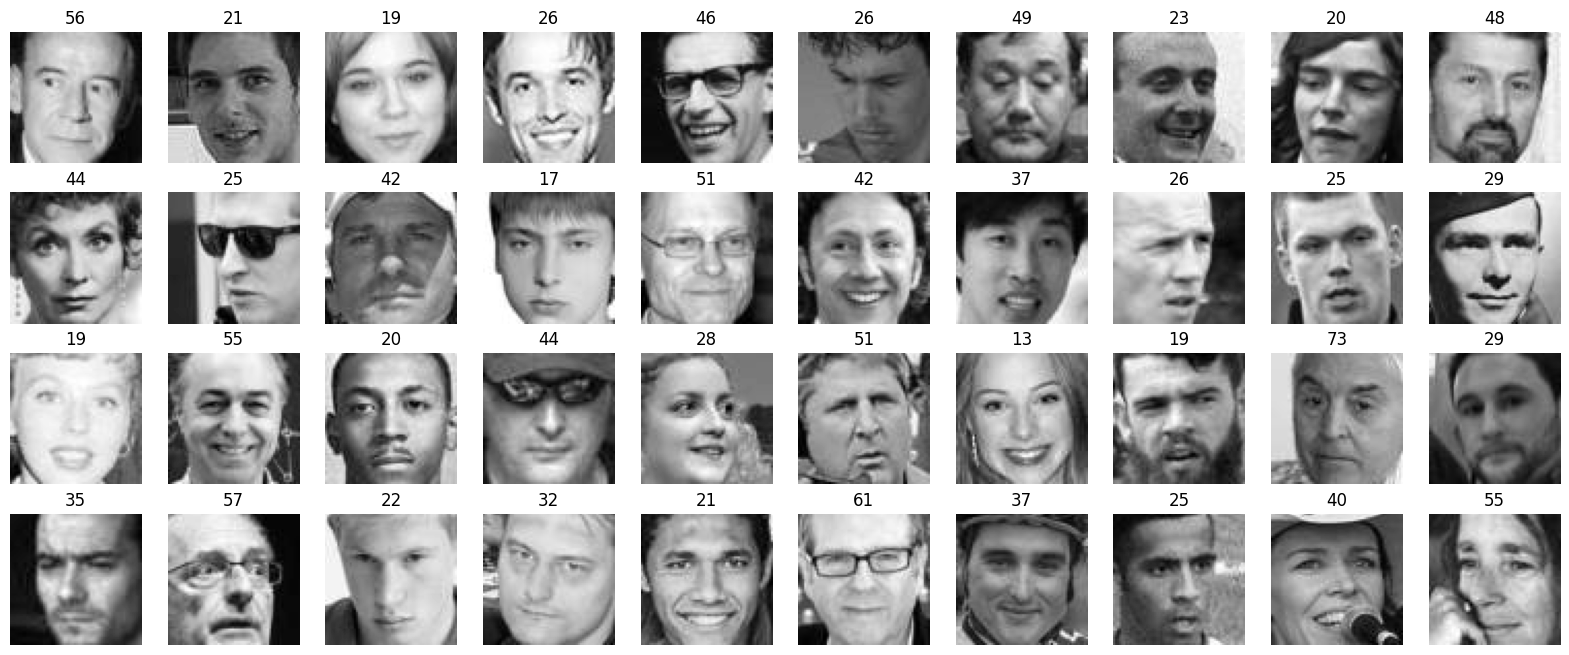

In [8]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')